# General analysis of a simulation

In [1]:
using HDF5
using PyPlot

In [2]:
thermostat = "Logistic"
filename = "fcc256.hdf5" #The file must exist in the HDF5 folder
file = h5open("../data/$(thermostat)/HDF5/$filename", "r");

In [3]:
sim = read(file);

In [4]:
t = sim["t"]
E = sim["E"]
K = sim["K"]
U = sim["U"];
T = sim["T"]
i = sim["invariant"]
zeta = sim["zeta"]
nu = sim["nu"]
vrandatom = sim["vrandatom"];

In [5]:
N = read(attrs(file)["N"])  
dt = read(attrs(file)["deltat"])  
Q = read(attrs(file)["Q"])   ##Parameter associated to the thermostat

2.0

## Equilibrium

The approach to follows is to plot the temperature and establish the time when the equilibrium is reached, in order to discard the initial data

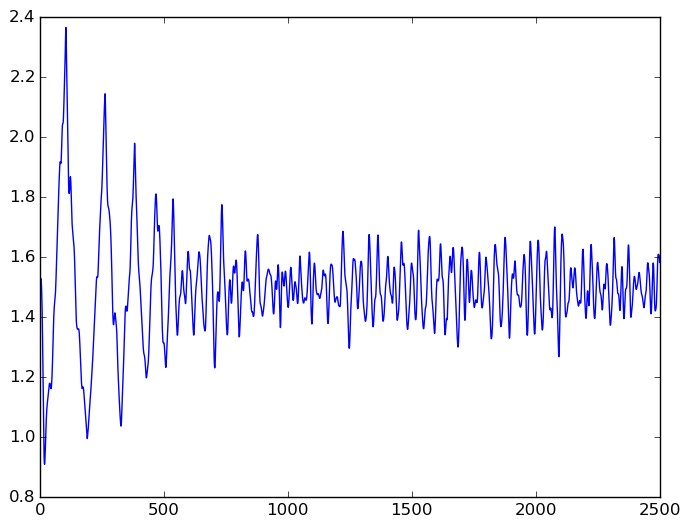

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f74a7d21350>

In [6]:
plot(T[1:2500])

In [7]:
stepeq = 1000;  ##Step where the equilibrium seems to be a fact

1000

## Units

For going from reduced units (with `*`) to physical units one uses the following rules (taken from **Frenkel's book**)

+ $U = U^* \epsilon$ 
+ $\rho = \dfrac{\rho^* m}{\sigma^3}$ (in $kg/m^3$)
+ $\rho = \dfrac{\rho^* m}{\sigma^3 1000 \rm{AW}}$ (in $mol/L$)
+ $T = T^* \dfrac{\epsilon}{k_B}$
+ $C_v = C_v^*\dfrac{k_B AW}{m}$
+ $\Delta t = \Delta t^* \sigma \sqrt{\dfrac{m}{\epsilon}}$

Where AW stands for atomic weight.

In particular for Ar, the following data are used

| Quantity | Typical value |
| ---------|:-------------- |
| $\dfrac{\epsilon}{k_B}$ | $119.8  K$ |
| $\sigma$ | $3.405 x 10^{-10}  m$ |
| $m$ | $6.69 x 10^{-26}$  kg |
| $AW$ | $0.03994$ kg/mol |

With that, we convert the data used in the simulation as follows:


In [8]:
σ = 3.405e-10 
m = 6.69e-26
kb = 1.38064852e-23
ratio = 119.8
ϵ = kb*ratio
AW = 0.039948
Text = read(attrs(file)["T"])  
ρ = read(attrs(file)["rho"]); 
rhophysical = ρ*m/(σ^3*1000*AW)
Tphysical = Text*ratio
deltat = dt*σ*sqrt(m/ϵ)
println("Treduced = $(Text), Tphysical = $(Tphysical) K, rhophysical = $(rhophysical) mol/L, tphysical = $(deltat) s")

Treduced = 1.5, Tphysical = 179.7 K, rhophysical = 33.936708244735506 mol/L, tphysical = 1.0827550166634764e-14 s


We then look for the physical properties at the [NIST webpage](http://webbook.nist.gov/chemistry/fluid/). In particular, for the heat capacity $C_v$. In this case its value is $18.669$ J/molK. We proceed to convert it to reduced units.


In [9]:
Cv_reduced = 18.669*m/(kb*AW)
println("Cv_reduced = $Cv_reduced")

Cv_reduced = 2.264482665749965


This is the value that we will compare with the fluctuations in energy 

## Fluctuations

General formula for fluctuations in energy in the canonical ensemble 

$$ C_vNk_B T^2 = \langle (H - \langle H \rangle)^2 \rangle  $$

In our case, we use the mean value of T  (from [Valenzuela's paper](http://www.tandfonline.com/doi/abs/10.1080/08927022.2014.895077?journalCode=gmos20#.Vw08mCYtg8o))

$$ C_v = \dfrac{\langle (H - \langle H \rangle)^2 \rangle}{N k_B \langle T \rangle ^2} $$

And the reduced heat capacity is

$$ C_v^* = \dfrac{\langle (H - \langle H \rangle)^2 \rangle}{N \langle T^* \rangle ^2} $$

In [11]:
e = E[stepeq:end]; temp = T[stepeq:end];

In [12]:
flucte = mean((e - mean(e)).^2)

1309.568103046662

In [13]:
Cv = flucte/(N*mean(temp)^2)

2.273404119799525

## Covariance 

The covariance between the Kinetic and potential energy is defined by the formula

$$
cov^*(K,U) = \frac{\langle (K - \bar{K})(U - \bar{U})}{N \langle T^* \rangle}^2
$$

In [14]:
k = K[stepeq:end]; u = U[stepeq:end];

In [15]:
mean((k - mean(k)).* (u - mean(u)))/(N*mean(temp)^2)

-0.00205789978216383

## Invariant

The invariant is analyzed after equilibrium is reached. In particular the scaled invariant is analyzed

In [16]:
inv = i[stepeq:end];

In [17]:
invred = (inv - inv[1])./inv[1];
time = t[stepeq:end] - t[stepeq];

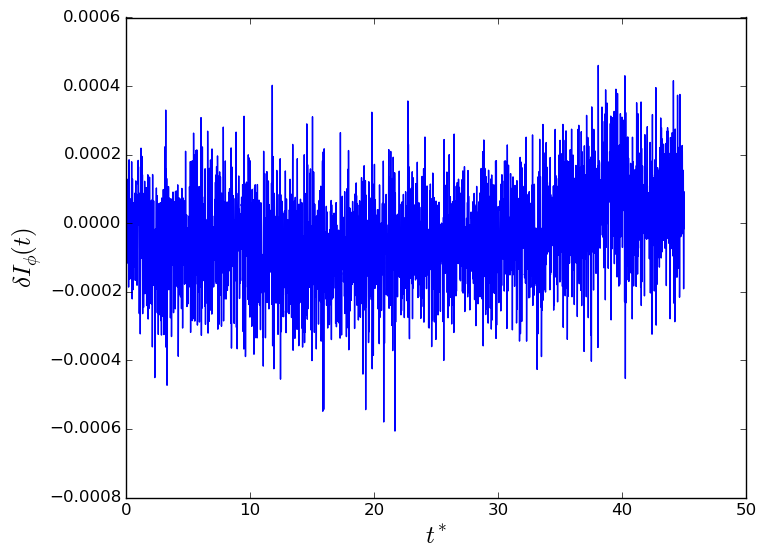

PyObject <matplotlib.text.Text object at 0x7f74a7cb98d0>

In [18]:
plot(time,invred)
plt[:xlabel](L"t^*", fontsize =18)
plt[:ylabel](L"\delta I_{\phi}(t)", fontsize = 18)

## Energy Distribution

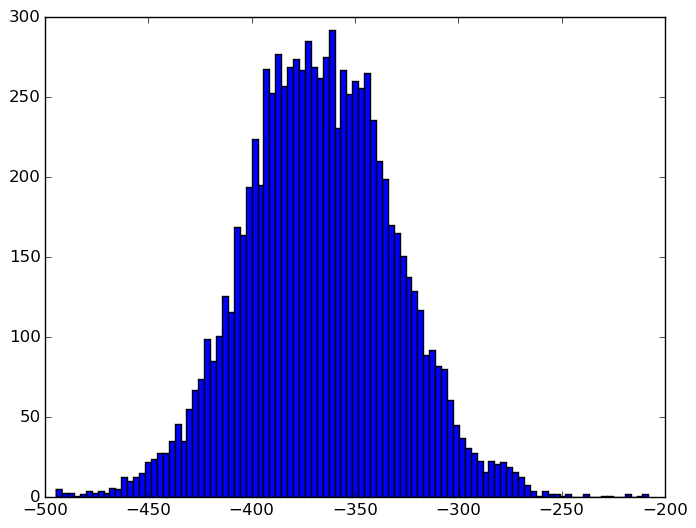

([5.0,3.0,3.0,1.0,2.0,4.0,3.0,4.0,3.0,6.0  …  0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,2.0],[-494.613,-491.748,-488.883,-486.017,-483.152,-480.287,-477.422,-474.556,-471.691,-468.826  …  -233.868,-231.003,-228.138,-225.272,-222.407,-219.542,-216.676,-213.811,-210.946,-208.08],Any[PyObject <matplotlib.patches.Rectangle object at 0x7f74a7827690>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a7827cd0>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a7832390>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a7832a10>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a7832f10>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a7840750>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a7840dd0>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a77cb490>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a77cbb10>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a77da1d0>  …  PyObject <matplotlib.patches.Rectangle object at 0x7f74a7607610>,PyObj

In [21]:
plt[:hist](e,100)

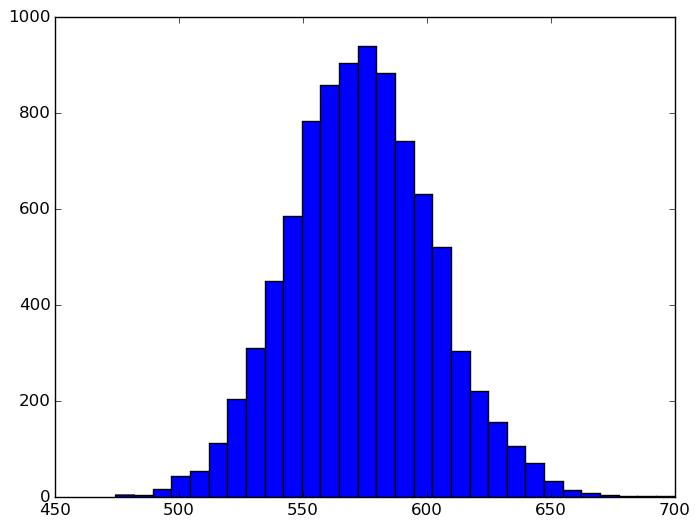

([5.0,6.0,17.0,45.0,55.0,113.0,205.0,311.0,450.0,587.0  …  157.0,107.0,72.0,34.0,15.0,10.0,5.0,2.0,4.0,3.0],[474.409,481.92,489.431,496.943,504.454,511.965,519.476,526.988,534.499,542.01  …  632.145,639.656,647.168,654.679,662.19,669.701,677.213,684.724,692.235,699.746],Any[PyObject <matplotlib.patches.Rectangle object at 0x7f74a751a090>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a751a6d0>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a751ad50>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a7525410>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a7525a90>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a7525f90>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a75337d0>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a7533e50>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a753e510>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a753eb90>  …  PyObject <matplotlib.patches.Rectangle object at 0x7f74a75f7f50>,PyObje

In [22]:
plt[:hist](k,30)

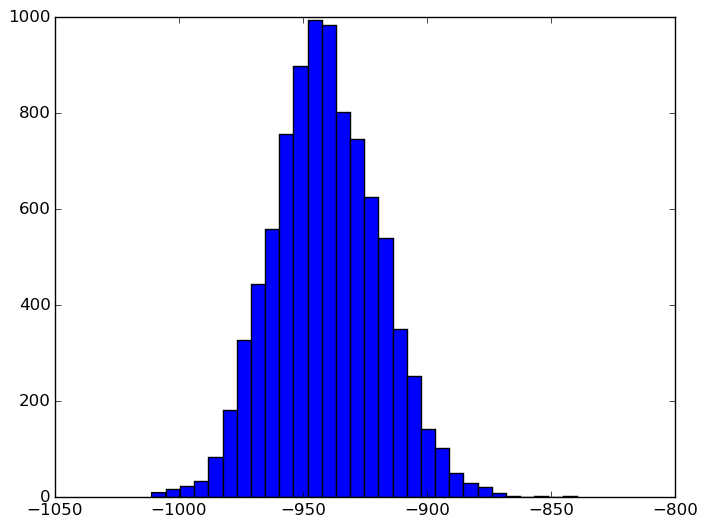

([10.0,17.0,23.0,34.0,85.0,182.0,328.0,444.0,559.0,757.0  …  103.0,50.0,30.0,21.0,9.0,3.0,1.0,2.0,1.0,4.0],[-1011.05,-1005.33,-999.62,-993.906,-988.192,-982.478,-976.764,-971.05,-965.335,-959.621  …  -891.052,-885.338,-879.624,-873.91,-868.196,-862.481,-856.767,-851.053,-845.339,-839.625],Any[PyObject <matplotlib.patches.Rectangle object at 0x7f74a73cdc50>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a73d82d0>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a73d8950>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a73d8fd0>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a73e6690>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a73e6d10>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a73f43d0>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a73f4a50>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a73f4f50>,PyObject <matplotlib.patches.Rectangle object at 0x7f74a7402790>  …  PyObject <matplotlib.patches.Rectangle object at 0x7

In [23]:
plt[:hist](u,30)


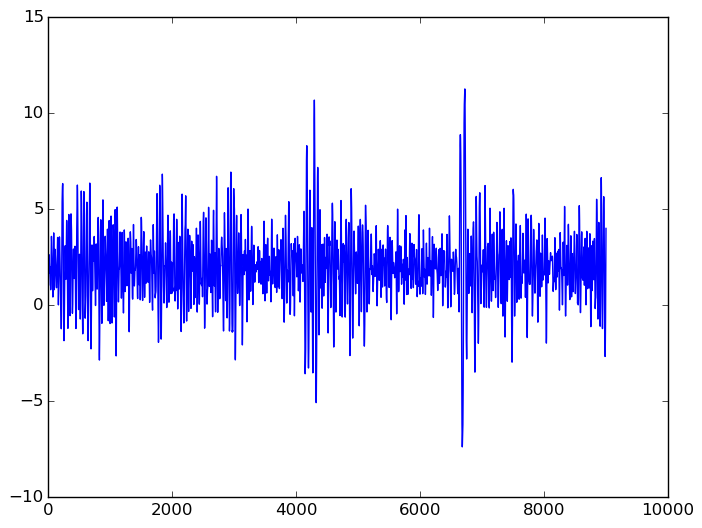

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f74a72f0510>

In [24]:
plot(zeta[stepeq:end])

## Test Holian 
Based on relations between first momenta of the temperature (check [Holian's paper](http://journals.aps.org/pre/pdf/10.1103/PhysRevE.52.2338) for details)

In [32]:
meanT = mean(T[stepeq:end])

1.500050017106758

In [33]:
varianceT = var(T[stepeq:end])

0.005790454903297624

In [35]:
varianceT*3*(N-1)/(2*meanT^2)   #Expected value = 1.0

0.9843116892357097